In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import subprocess
from dtw import correlate
import json
import librosa
import IPython.display as ipd
import math
import csv

MAX_AUDIO_DURATION_MS = 4 * 1000
MAX_SAMPLE_COMPARISON_COUNT = 1000

apppath = os.path.expanduser(os.getcwd() + '/')
mediapath = os.path.expanduser('/media/andrus/ANDRUS/freesound-crawler/')
#processedpath = os.path.expanduser('/Volumes/LaCie/freesound-crawler/')
processedpath = os.path.join(mediapath, 'processed/')
soxipath = os.path.join(processedpath, 'soxi/')
wavpath = os.path.join(processedpath, 'wav/')
audiopath = os.path.join(processedpath, 'audio/')
normalizedpath = os.path.join(processedpath, 'normalized/')
dtwpath = os.path.join(processedpath, 'dtw/')
excludedpath = os.path.join(processedpath, 'excluded/')
extensionpath = os.path.join(apppath, 'Extension/data/')
extensionsamplepath = os.path.join(extensionpath, 'samples/')
librarypath = os.path.join(mediapath, 'downloads/')
metadatapath = os.path.join(mediapath, 'metadata/')
metadatacsvpath = os.path.join(processedpath, 'metadata.csv')
allowedfileformats = ['wav', 'aiff', 'flac', 'ogg', 'mp3', 'm4a']
audiofileformat = 'm4a'

for p in [processedpath, soxipath, wavpath, audiopath, normalizedpath, dtwpath, excludedpath, extensionpath, extensionsamplepath]:
    if not os.path.exists(p):
        os.makedirs(p)

In [2]:
ids = [f for f in os.listdir(metadatapath)]
print(len(ids))

if not os.path.exists(metadatacsvpath):
    fieldnames = ['id', 'duration', 'downloads', 'rating', 'numratings', 'tags']
    rows = []

    for id in ids:        
        with open(metadatapath + "/" + id) as file:
            try:
                id = int(id)
                line = file.readlines()[0]
                arguments = line.split('|')
                duration = int(arguments[0].split('duration:')[1])
                downloads = int(arguments[1].split('downloads:')[1])
                rating = int(arguments[2].split('rating:')[1])
                numratings = int(arguments[3].split('numratings:')[1])
                tags = arguments[4].split('tags:')[1]
                row = {
                    'id': id,
                    'duration': duration,
                    'downloads': downloads,
                    'rating': rating,
                    'numratings': numratings,
                    'tags': tags
                }
                rows.append(row)
            except Exception as e:
                print(e)

    with open(metadatacsvpath, 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
        writer.writeheader()
        writer.writerows(rows)
        
def read_csv(filename):
    with open(filename) as f:
        file_data = csv.reader(f)
        headers = next(file_data)
        return [dict(zip(headers, i)) for i in file_data] 

metadata = read_csv(metadatacsvpath)

68455


In [3]:
excluded = [f for f in os.listdir(excludedpath)]
excluded = [f for f in excluded if f.endswith(audiofileformat)]
excluded = [f.split('.' + audiofileformat)[0] for f in excluded]

print(len(excluded))

973


In [4]:
DOWNLOADS_THRESHOLD = 25
RATING_THRESHOLD = 80
MIN_NUMRATINGS = 4

scored = []
for sample in metadata:            
    id = sample['id']
    if id in excluded:
        continue

    duration = int(sample['duration'])
    downloads = int(sample['downloads'])
    rating = int(sample['rating'])
    numratings = int(sample['numratings'])
    tags = sample['tags']

    if len(tags) > 0 and downloads >= DOWNLOADS_THRESHOLD and rating >= RATING_THRESHOLD and numratings >= MIN_NUMRATINGS:
        row = [id, duration, downloads, rating, numratings, tags, rating * downloads]
        scored.append(row)

print(len(scored))

scored.sort(key=lambda x: int(x[6]))
scored.reverse()

print(scored[0])

2497
['60009', 319, 67854, 86, 561, 'zoom-h2,domain,public,punch,swhish,swish,swoosh,swosh,whip,whoosh,woosh,stick,swash,zoom,swing,wind,wisch,attack,bamboo,cut,wish,flup,h2,luft,weapon,public-domain,air', 5835444]


In [5]:
samples = {}

for row in scored:
    id = row[0]
    samples[id] = {
        'duration': row[1],
        'downloads': row[2],
        'rating': row[3],
        'numratings': row[4],
        'tags': row[5],
        'score': row[6],
    }
    
print(samples[scored[0][0]])

{'duration': 319, 'downloads': 67854, 'rating': 86, 'numratings': 561, 'tags': 'zoom-h2,domain,public,punch,swhish,swish,swoosh,swosh,whip,whoosh,woosh,stick,swash,zoom,swing,wind,wisch,attack,bamboo,cut,wish,flup,h2,luft,weapon,public-domain,air', 'score': 5835444}


In [6]:
def get_fileformat(filename):
    return filename.split('.')[len(filename.split('.')) - 1]

all_filenames = [f for f in os.listdir(librarypath)]
fileformats = {}
for filename in all_filenames:
    fileformat = get_fileformat(filename)
    
    if fileformat not in fileformats:
        fileformats[fileformat] = 0
         
    fileformats[fileformat] = fileformats[fileformat] + 1
    
print('fileformats', fileformats)
print('all_filenames:', len(all_filenames))

processedfilenames = [f for f in os.listdir(audiopath) if f.endswith(audiofileformat)]

filenames = [f for f in os.listdir(librarypath) if f.endswith(tuple(allowedfileformats))]
filenames = [f for f in filenames if f.count('__') == 2]
filtered = []

for filename in filenames:
    id = filename.split('__')[0]
    
    for row in scored:
        if row[0] == id:
            filtered.append(filename)
filenames = filtered
print('filtered filenames', len(filenames))

fileformats {'DS_Store': 1, 'wav': 46250, 'aiff': 19174, 'mp3': 2936, 'flac': 2888, 'ogg': 679, 'crdownload': 15, 'm4a': 142}
all_filenames: 72085
filtered filenames 2493


In [7]:
def create_or_read_file(command, outfilename):
    if os.path.exists(outfilename):
        f = open(outfilename, "r")
        out = ''.join(f.readlines())
        f.close()
        return out
    else:
        try:
            out = str(subprocess.check_output(command).decode(encoding="utf-8")).strip().replace('\\n', '').replace("'", "")

            with open(outfilename, 'w') as file:
                file.write(out)

            return out
        except Exception as e:
            return 

In [8]:
def process(command, cwd="/"):
    subprocess.check_output(command, cwd=cwd)

res = []
for filename in filenames:
    try:
        fileartist = filename.split("__")[1].split("__")[0]
        fileid = filename.split('__')[0]
        audiofilename = fileid + '.' + audiofileformat
        
        if samples[fileid]['duration'] > MAX_AUDIO_DURATION_MS:
            continue

        if audiofilename not in processedfilenames:
            process(['ffmpeg-normalize', librarypath + filename, '-o', normalizedpath + filename])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-acodec', 'pcm_s16le', '-ac', '1', '-ar', '100', '-threads', '6', '-y', wavpath + fileid + '.wav'])
            process(['ffmpeg', '-loglevel', 'error', '-i', normalizedpath + filename, '-c:a', 'aac', '-ar', '44100', '-threads', '6', '-y', audiopath + audiofilename])
        
        res.append(audiofilename)
    except Exception as e:
        print(e)

filenames = res
print(filenames)
print(len(filenames))

ERROR: Error while running command /usr/bin/ffmpeg -y -nostdin -i /media/andrus/ANDRUS/freesound-crawler/downloads/103998__rutgermuller__wood-knocks.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=26.88:measured_i=-24.18:measured_lra=0.0:measured_tp=-1.45:measured_thresh=-35.64:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /tmp/tmpdx_qpmkj/out.aiff! Error: Error running command ['/usr/bin/ffmpeg', '-y', '-nostdin', '-i', '/media/andrus/ANDRUS/freesound-crawler/downloads/103998__rutgermuller__wood-knocks.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=26.88:measured_i=-24.18:measured_lra=0.0:measured_tp=-1.45:measured_thresh=-35.64:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/tmp/tmpdx_qpmkj/out.aiff']: ffmpeg version 4.3.

Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/103998__rutgermuller__wood-knocks.aiff', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/103998__rutgermuller__wood-knocks.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/bin/ffmpeg -y -nostdin -i /media/andrus/ANDRUS/freesound-crawler/downloads/10436__batchku__gbell-7-1-pp.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-2.88:measured_i=-36.62:measured_lra=10.7:measured_tp=-17.82:measured_thresh=-49.74:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /tmp/tmpwhk8p0je/out.aiff! Error: Error running command ['/usr/bin/ffmpeg', '-y', '-nostdin', '-i', '/media/andrus/ANDRUS/freesound-crawler/downloads/10436__batchku__gbell-7-1-pp.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-2.88:measured_i=-36.62:measured_lra=10.7:measured_tp=-17.82:measured_thresh=-49.74:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/tmp/tmpwhk8p0je/out.aiff']: ffmpeg version 4.3.5-0+de

Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/10436__batchku__gbell-7-1-pp.aiff', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/10436__batchku__gbell-7-1-pp.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/bin/ffmpeg -y -nostdin -i /media/andrus/ANDRUS/freesound-crawler/downloads/10439__batchku__gbell-8-1-pp.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-1.92:measured_i=-38.3:measured_lra=13.8:measured_tp=-17.41:measured_thresh=-51.39:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /tmp/tmpzu5zmt4r/out.aiff! Error: Error running command ['/usr/bin/ffmpeg', '-y', '-nostdin', '-i', '/media/andrus/ANDRUS/freesound-crawler/downloads/10439__batchku__gbell-8-1-pp.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-1.92:measured_i=-38.3:measured_lra=13.8:measured_tp=-17.41:measured_thresh=-51.39:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/tmp/tmpzu5zmt4r/out.aiff']: ffmpeg version 4.3.5-0+deb1

Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/10439__batchku__gbell-8-1-pp.aiff', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/10439__batchku__gbell-8-1-pp.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/bin/ffmpeg -y -nostdin -i /media/andrus/ANDRUS/freesound-crawler/downloads/119077__domrodrig__door-opening-unlocking-1-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=16.98:measured_i=-33.75:measured_lra=0.0:measured_tp=-10.29:measured_thresh=-45.77:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /tmp/tmpbwcoma32/out.aiff! Error: Error running command ['/usr/bin/ffmpeg', '-y', '-nostdin', '-i', '/media/andrus/ANDRUS/freesound-crawler/downloads/119077__domrodrig__door-opening-unlocking-1-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=16.98:measured_i=-33.75:measured_lra=0.0:measured_tp=-10.29:measured_thresh=-45.77:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/tmp/tmpbwcoma32/out.a

Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/119077__domrodrig__door-opening-unlocking-1-2.aiff', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/119077__domrodrig__door-opening-unlocking-1-2.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/bin/ffmpeg -y -nostdin -i /media/andrus/ANDRUS/freesound-crawler/downloads/119088__domrodrig__grabbing-knife-sudden-1-2.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-24.54:measured_lra=0.0:measured_tp=-8.22:measured_thresh=-39.28:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /tmp/tmpjfxfm98k/out.aiff! Error: Error running command ['/usr/bin/ffmpeg', '-y', '-nostdin', '-i', '/media/andrus/ANDRUS/freesound-crawler/downloads/119088__domrodrig__grabbing-knife-sudden-1-2.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.0:measured_i=-24.54:measured_lra=0.0:measured_tp=-8.22:measured_thresh=-39.28:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/tmp/tmpjfxfm98k/out.aiff']: f

Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/119088__domrodrig__grabbing-knife-sudden-1-2.aiff', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/119088__domrodrig__grabbing-knife-sudden-1-2.aiff']' returned non-zero exit status 1.


ERROR: Error while running command /usr/bin/ffmpeg -y -nostdin -i /media/andrus/ANDRUS/freesound-crawler/downloads/128256__rebeat__dainty-break.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=13.58:measured_i=-24.8:measured_lra=0.0:measured_tp=0.44:measured_thresh=-34.8:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /tmp/tmplse8s_qq/out.aiff! Error: Error running command ['/usr/bin/ffmpeg', '-y', '-nostdin', '-i', '/media/andrus/ANDRUS/freesound-crawler/downloads/128256__rebeat__dainty-break.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=13.58:measured_i=-24.8:measured_lra=0.0:measured_tp=0.44:measured_thresh=-34.8:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/tmp/tmplse8s_qq/out.aiff']: ffmpeg version 4.3.5-0+deb11u1 Copy

Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/128256__rebeat__dainty-break.aiff', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/128256__rebeat__dainty-break.aiff']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/154888__unfa__beep-bad.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/154888__unfa__beep-bad.ogg']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/155861__unfa__alright-1.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/155861__unfa__alright-1.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/161340__qubodup__us-military-soldier-shouting-whoo.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/161340__qubodup__us-military-soldier-shouting-whoo.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/161341__qubodup__howitzer-artillery-gun-shot-sound-effect-03.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/161341__qubodup__howitzer-artillery-gun-shot-sound-effect-03.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/161343__qubodup__howitzer-artillery-gun-shot-sound-effect-01.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/161343__qubodup__howitzer-artillery-gun-shot-sound-effect-01.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/161654__qubodup__war-game-battle-level-up.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/161654__qubodup__war-game-battle-level-up.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/161967__qubodup__to-war-assault-drill-sergeant-shout.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/161967__qubodup__to-war-assault-drill-sergeant-shout.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/161970__qubodup__firing-mortar-at-shooting-range.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/161970__qubodup__firing-mortar-at-shooting-range.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/162401__qubodup__m203-grenade-launcher-2.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/162401__qubodup__m203-grenade-launcher-2.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/162402__qubodup__m203-grenade-launcher-1.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/162402__qubodup__m203-grenade-launcher-1.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/162465__kastenfrosch__lostitem.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/162465__kastenfrosch__lostitem.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/162470__kastenfrosch__sprunginnen.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/162470__kastenfrosch__sprunginnen.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/162479__kastenfrosch__beam.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/162479__kastenfrosch__beam.mp3']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/166535__qubodup__hidden-spike-trap.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/166535__qubodup__hidden-spike-trap.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/169727__qubodup__horror-sliding-transition.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/169727__qubodup__horror-sliding-transition.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/171615__pjkasinski3__holster-1.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/171615__pjkasinski3__holster-1.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/171619__pjkasinski3__rem-870-pump-2.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/171619__pjkasinski3__rem-870-pump-2.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/bin/ffmpeg -y -nostdin -i /media/andrus/ANDRUS/freesound-crawler/downloads/172889__candlegravity__bell-bubbler-loop-ii.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-26.39:measured_lra=0.0:measured_tp=-11.32:measured_thresh=-37.42:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /tmp/tmpl242ir9b/out.aiff! Error: Error running command ['/usr/bin/ffmpeg', '-y', '-nostdin', '-i', '/media/andrus/ANDRUS/freesound-crawler/downloads/172889__candlegravity__bell-bubbler-loop-ii.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.01:measured_i=-26.39:measured_lra=0.0:measured_tp=-11.32:measured_thresh=-37.42:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/tmp/tmpl242ir9b/out.aiff'

Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/172889__candlegravity__bell-bubbler-loop-ii.aiff', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/172889__candlegravity__bell-bubbler-loop-ii.aiff']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/188488__unfa__scream-let-s-go.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/188488__unfa__scream-let-s-go.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/18934__roil-noise__rgs-breakcore-glitch-loop1.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/18934__roil-noise__rgs-breakcore-glitch-loop1.mp3']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/198248__unfa__laughter-04.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/198248__unfa__laughter-04.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/213232__unfa__huh-haaa-dry.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/213232__unfa__huh-haaa-dry.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/215003__waveplaysfx__drumloop-119-bpm-edm-drum-loop-001.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/215003__waveplaysfx__drumloop-119-bpm-edm-drum-loop-001.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/218043__waveplaysfx__sfx-bird-chirp-click-thing-hi-bip-thing-thinger.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/218043__waveplaysfx__sfx-bird-chirp-click-thing-hi-bip-thing-thinger.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/277643__coral-island-studios__button-14.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/277643__coral-island-studios__button-14.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/323184__alivvie__hai-hai.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/323184__alivvie__hai-hai.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/323190__alivvie__complain1.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/323190__alivvie__complain1.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/323195__alivvie__ii-normal.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/323195__alivvie__ii-normal.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/323196__alivvie__ii-high.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/323196__alivvie__ii-high.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/323198__alivvie__where-is-the-bathroom.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/323198__alivvie__where-is-the-bathroom.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/323199__alivvie__welcome-back.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/323199__alivvie__welcome-back.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/323200__alivvie__excuse-me.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/323200__alivvie__excuse-me.mp3']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/340809__cabled-mess__retro-sci-fi-horror-06.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/340809__cabled-mess__retro-sci-fi-horror-06.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/340810__cabled-mess__alien-interface-communication-sound.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/340810__cabled-mess__alien-interface-communication-sound.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/349655__insanity54__c4-beep1.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/349655__insanity54__c4-beep1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395324__ihitokage__body-falling-on-the-ground-1.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395324__ihitokage__body-falling-on-the-ground-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395325__ihitokage__body-falling-on-the-ground-2.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395325__ihitokage__body-falling-on-the-ground-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395326__ihitokage__block-2.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395326__ihitokage__block-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395327__ihitokage__block-1.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395327__ihitokage__block-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395331__ihitokage__body-falling-on-the-ground-1.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395331__ihitokage__body-falling-on-the-ground-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395333__ihitokage__grab-2.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395333__ihitokage__grab-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395347__ihitokage__slap-2.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395347__ihitokage__slap-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395348__ihitokage__slap-3.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395348__ihitokage__slap-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395350__ihitokage__slap-1.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395350__ihitokage__slap-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395351__ihitokage__woosh-3.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395351__ihitokage__woosh-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395352__ihitokage__woosh-8.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395352__ihitokage__woosh-8.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395353__ihitokage__woosh-9.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395353__ihitokage__woosh-9.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395359__ihitokage__hit-3.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395359__ihitokage__hit-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395360__ihitokage__hit-2.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395360__ihitokage__hit-2.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395361__ihitokage__hit-1.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395361__ihitokage__hit-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395362__ihitokage__hit-6.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395362__ihitokage__hit-6.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/395366__ihitokage__swish-3.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/395366__ihitokage__swish-3.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/399621__soundsforhim__sigh-3.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/399621__soundsforhim__sigh-3.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/399626__soundsforhim__male-grunt.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/399626__soundsforhim__male-grunt.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/407465__loyalty-freak-music__cancel.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/407465__loyalty-freak-music__cancel.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/407466__loyalty-freak-music__buzzer.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/407466__loyalty-freak-music__buzzer.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/435695__samsterbirdies__big-boom.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/435695__samsterbirdies__big-boom.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/448393__lordforklift__satisfying-plastic-handle-unlock.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/448393__lordforklift__satisfying-plastic-handle-unlock.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/448394__lordforklift__fuze-switch-flick.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/448394__lordforklift__fuze-switch-flick.ogg']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/450725__kyles__basketball-grab-2versions.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/450725__kyles__basketball-grab-2versions.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/451464__kyles__police-whistle-nearby-good-detail-and-echo-india.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/451464__kyles__police-whistle-nearby-good-detail-and-echo-india.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/453333__kyles__metal-crank-groan.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/453333__kyles__metal-crank-groan.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/453347__kyles__metal-piece-heavy-drag-on-floor.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/453347__kyles__metal-piece-heavy-drag-on-floor.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/458663__jorgerosa__light-beam-1.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/458663__jorgerosa__light-beam-1.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/463817__se2001__chipmunk-laugh.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/463817__se2001__chipmunk-laugh.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/463818__se2001__another-chipmunk-laugh.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/463818__se2001__another-chipmunk-laugh.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/49026__suspiciononline__kit-hat1.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/49026__suspiciononline__kit-hat1.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/49028__suspiciononline__kit-tamb.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/49028__suspiciononline__kit-tamb.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/49042__suspiciononline__moca-style-basedrum-02.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/49042__suspiciononline__moca-style-basedrum-02.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/512389__kievinay__bass-impact-ki-01.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/512389__kievinay__bass-impact-ki-01.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/521950__kastenfrosch__water-impact.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/521950__kastenfrosch__water-impact.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/521951__kastenfrosch__weird-grunt.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/521951__kastenfrosch__weird-grunt.ogg']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/534110__pbimal__rubber-ball-01.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/534110__pbimal__rubber-ball-01.flac']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/536732__egomassive__caw.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/536732__egomassive__caw.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/536736__egomassive__chop.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/536736__egomassive__chop.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/536746__egomassive__pig.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/536746__egomassive__pig.ogg']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/536750__egomassive__gruntf.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/536750__egomassive__gruntf.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/537816__legnalegna55__hey-hey-you.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/537816__legnalegna55__hey-hey-you.mp3']' returned non-zero exit status 1.


ERROR: Output extension ogg does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/545338__stwime__beep-boop.ogg', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/545338__stwime__beep-boop.ogg']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/578376__nomiqbomi__shock-stab-02.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/578376__nomiqbomi__shock-stab-02.mp3']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/578800__nomiqbomi__sparkle-1.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/578800__nomiqbomi__sparkle-1.mp3']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/584179__unfa__radar.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/584179__unfa__radar.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/59989__qubodup__swosh-02.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/59989__qubodup__swosh-02.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/59990__qubodup__swosh-03.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/59990__qubodup__swosh-03.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/59991__qubodup__swosh-04.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/59991__qubodup__swosh-04.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/59995__qubodup__swosh-08.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/59995__qubodup__swosh-08.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/59996__qubodup__swoosh-wind-09.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/59996__qubodup__swoosh-wind-09.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/59999__qubodup__sword-or-bullet-swish-swosh-12.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/59999__qubodup__sword-or-bullet-swish-swosh-12.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60000__qubodup__13th-whoosh-swing-sound.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60000__qubodup__13th-whoosh-swing-sound.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60001__qubodup__air-cutting-14.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60001__qubodup__air-cutting-14.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60002__qubodup__swoosh-15-windy.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60002__qubodup__swoosh-15-windy.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60004__qubodup__fast-sword-swing-sound.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60004__qubodup__fast-sword-swing-sound.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60005__qubodup__sharp-swosh-18.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60005__qubodup__sharp-swosh-18.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60006__qubodup__swoosh-metal-rod-swing-sound-made-with-bamboo-stick.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60008__qubodup__21th-air-movement-sound.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60008__qubodup__21th-air-movement-sound.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60009__qubodup__swosh-22.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60009__qubodup__swosh-22.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60011__qubodup__whoosh-24.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60011__qubodup__whoosh-24.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60014__qubodup__swosh-27.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60014__qubodup__swosh-27.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60015__qubodup__writing-z-for-zorro-in-the-air.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60015__qubodup__writing-z-for-zorro-in-the-air.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/60016__qubodup__windy-movement-29.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/60016__qubodup__windy-movement-29.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/612686__foleyhaven__pig-grunt-04.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/612686__foleyhaven__pig-grunt-04.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/618994__mrrap4food__gun-silencer.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/618994__mrrap4food__gun-silencer.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/bin/ffmpeg -y -nostdin -i /media/andrus/ANDRUS/freesound-crawler/downloads/625__memexikon__duoshake.wav -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-9.53:measured_lra=0.0:measured_tp=1.94:measured_thresh=-21.23:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s8 -c:s copy /tmp/tmpro0odnpn/out.wav! Error: Error running command ['/usr/bin/ffmpeg', '-y', '-nostdin', '-i', '/media/andrus/ANDRUS/freesound-crawler/downloads/625__memexikon__duoshake.wav', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.01:measured_i=-9.53:measured_lra=0.0:measured_tp=1.94:measured_thresh=-21.23:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s8', '-c:s', 'copy', '/tmp/tmpro0odnpn/out.wav']: ffmpeg version 4.3.5-0+deb11u1 Copyright (c) 2000-202

Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/625__memexikon__duoshake.wav', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/625__memexikon__duoshake.wav']' returned non-zero exit status 1.


ERROR: Error while running command /usr/bin/ffmpeg -y -nostdin -i /media/andrus/ANDRUS/freesound-crawler/downloads/638__memexikon__lockjawnetb.wav -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.02:measured_i=-9.75:measured_lra=0.0:measured_tp=-0.18:measured_thresh=-19.75:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s8 -c:s copy /tmp/tmpj57zoonh/out.wav! Error: Error running command ['/usr/bin/ffmpeg', '-y', '-nostdin', '-i', '/media/andrus/ANDRUS/freesound-crawler/downloads/638__memexikon__lockjawnetb.wav', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=-0.02:measured_i=-9.75:measured_lra=0.0:measured_tp=-0.18:measured_thresh=-19.75:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s8', '-c:s', 'copy', '/tmp/tmpj57zoonh/out.wav']: ffmpeg version 4.3.5-0+deb11u1 Copyright (c

Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/638__memexikon__lockjawnetb.wav', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/638__memexikon__lockjawnetb.wav']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/67648__qubodup__movement-right-there-soldier-radio-talk.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/67648__qubodup__movement-right-there-soldier-radio-talk.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/67662__qubodup__voice-male-radio-roger-that-2.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/67662__qubodup__voice-male-radio-roger-that-2.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/67665__qubodup__voice-male-radio-stand-by-1.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/67665__qubodup__voice-male-radio-stand-by-1.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/67666__qubodup__voice-male-radio-take-the-shot-1.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/67666__qubodup__voice-male-radio-take-the-shot-1.flac']' returned non-zero exit status 1.


ERROR: Output extension flac does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/90072__qubodup__uuh.flac', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/90072__qubodup__uuh.flac']' returned non-zero exit status 1.


ERROR: Output extension mp3 does not support PCM audio. Please choose a suitable audio codec with the -c:a option.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/94590__zgump__tr-loop-0501.mp3', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/94590__zgump__tr-loop-0501.mp3']' returned non-zero exit status 1.


ERROR: Error while running command /usr/bin/ffmpeg -y -nostdin -i /media/andrus/ANDRUS/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-35.06:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /tmp/tmp6184eg1p/out.aiff! Error: Error running command ['/usr/bin/ffmpeg', '-y', '-nostdin', '-i', '/media/andrus/ANDRUS/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-19.05:measured_lra=0.0:measured_tp=-1.48:measured_thresh=-35.06:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/tmp/tmp6184eg1p/out.aiff']: ffmpeg version 4.3.5-0+deb11u1 Copyright 

Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/9633__heigh-hoo__mute-1.aiff', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/9633__heigh-hoo__mute-1.aiff']' returned non-zero exit status 1.


Command '['ffmpeg-normalize', '/media/andrus/ANDRUS/freesound-crawler/downloads/98905__kuru23__goakick01.aiff', '-o', '/media/andrus/ANDRUS/freesound-crawler/processed/normalized/98905__kuru23__goakick01.aiff']' returned non-zero exit status 1.
['100052.m4a', '11557.m4a', '13119.m4a', '135479.m4a', '13857.m4a', '13858.m4a', '13957.m4a', '13964.m4a', '140459.m4a', '14066.m4a', '148979.m4a', '148998.m4a', '153277.m4a', '153519.m4a', '158896.m4a', '164640.m4a', '164642.m4a', '166886.m4a', '180966.m4a', '188383.m4a', '190096.m4a', '190112.m4a', '194060.m4a', '194071.m4a', '194072.m4a', '194080.m4a', '194105.m4a', '194112.m4a', '206152.m4a', '220156.m4a', '220178.m4a', '220190.m4a', '220196.m4a', '233646.m4a', '233647.m4a', '233649.m4a', '233650.m4a', '233651.m4a', '244437.m4a', '244450.m4a', '245951.m4a', '25670.m4a', '25694.m4a', '25706.m4a', '25708.m4a', '272460.m4a', '316573.m4a', '325262.m4a', '325270.m4a', '329355.m4a', '330359.m4a', '334864.m4a', '336615.m4a', '336914.m4a', '341229.m

ERROR: Error while running command /usr/bin/ffmpeg -y -nostdin -i /media/andrus/ANDRUS/freesound-crawler/downloads/98905__kuru23__goakick01.aiff -filter_complex '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-19.05:linear=true:print_format=json[norm0]' -map_metadata 0 -map_metadata:s:a:0 0:s:a:0 -map_chapters 0 -map '[norm0]' -c:a:0 pcm_s24le -c:s copy /tmp/tmpk7snh9kn/out.aiff! Error: Error running command ['/usr/bin/ffmpeg', '-y', '-nostdin', '-i', '/media/andrus/ANDRUS/freesound-crawler/downloads/98905__kuru23__goakick01.aiff', '-filter_complex', '[0:0]loudnorm=i=-23.0:lra=7.0:tp=-2.0:offset=0.05:measured_i=-9.05:measured_lra=0.0:measured_tp=0.01:measured_thresh=-19.05:linear=true:print_format=json[norm0]', '-map_metadata', '0', '-map_metadata:s:a:0', '0:s:a:0', '-map_chapters', '0', '-map', '[norm0]', '-c:a:0', 'pcm_s24le', '-c:s', 'copy', '/tmp/tmpk7snh9kn/out.aiff']: ffmpeg version 4.3.5-0+deb11u1 Copyright (c

In [9]:
df = pd.DataFrame()
out_distances = {}
full_distances = []

for leftfilename in filenames:
    leftid = leftfilename.split('.')[0]
    rightfilenames = filenames
    
    for righti, rightfilename in enumerate(rightfilenames):
        if (len(full_distances) % 100) == 0 and righti == 0:
            print(str(len(full_distances)) + " / " + str(len(filenames) * MAX_SAMPLE_COMPARISON_COUNT))
            
        if righti >= MAX_SAMPLE_COMPARISON_COUNT:
            continue
        
        if leftfilename == rightfilename:
            continue
            
        rightid = rightfilename.split('.')[0]
            
        try:
            correlation = correlate(wavpath, leftid, rightid, 'wav', dtwpath)
            
            if math.isinf(float(correlation)):
                continue
                
            if math.isnan(float(correlation)):
                continue
            
            df.loc[leftid, rightid] = correlation
            df.loc[rightid, leftid] = correlation

            if leftid not in out_distances:
                out_distances[leftid] = []
            
            duration = samples[leftid]['duration']
            out_distances[leftid].append([correlation, duration, int(rightid)])
            full_distances.append([correlation, leftid, rightid])

        except Exception as e:
            pass

for filename in out_distances:
    out_distances[filename] = sorted(out_distances[filename])
    
full_distances = sorted(full_distances)
print(len(full_distances))

0 / 99000
100 / 99000
100 / 99000
100 / 99000
100 / 99000
200 / 99000
200 / 99000
200 / 99000


/home/andrus/Projects/breathic/dtw.py:28: RuntimeWarning: invalid value encountered in divide
  normalized_samples = samples / max(samples)


300 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000


/home/andrus/Projects/breathic/dtw.py:28: RuntimeWarning: divide by zero encountered in divide
  normalized_samples = samples / max(samples)


400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
400 / 99000
500 / 99000
600 / 99000
600 / 99000
600 / 99000
650


In [10]:
delimiter = '|'
samples = {}
filtered_filenames = [f for f in os.listdir(dtwpath) if f.endswith('.dtw')]

for filename in filtered_filenames:
    filename = filename.split('.dtw')[0]
    left, right = filename.split(delimiter)
    
    if left not in samples:
        samples[left] = []
        
    if right not in samples:
        samples[right] = []
        
    samples[left].append(right)
    samples[right].append(left)

In [11]:
saved = [f for f in os.listdir(extensionsamplepath)]
saved = [f for f in saved if f.endswith(audiofileformat)]
saved = [f.split('.' + audiofileformat)[0] for f in saved]

print(len(saved))

25


In [12]:
for distance in full_distances:
    leftid = distance[1]
    
    if leftid in saved:
        continue

    source = audiopath + leftid + '.' + audiofileformat
    target = extensionsamplepath + leftid + '.' + audiofileformat
    process(['cp', source, target])

with open(extensionpath + 'distances.json', 'w') as fp:
    json.dump(out_distances, fp)

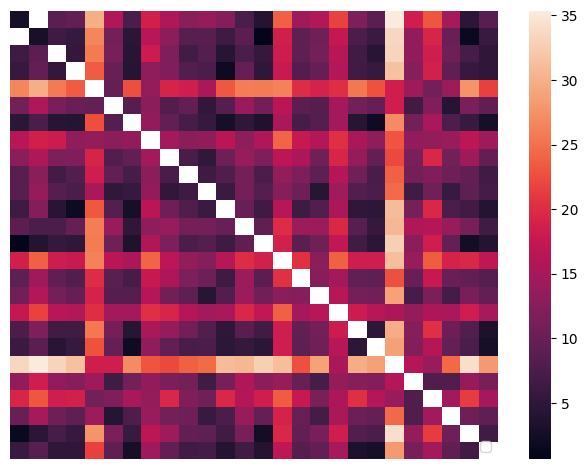

In [13]:
plot = sns.heatmap(df, xticklabels=False, yticklabels=False)
handles, labels = plot.get_legend_handles_labels()
plot.legend(reversed(handles), reversed(labels), title='', loc="lower right")
fig = plot.get_figure()
fig.tight_layout()

In [ ]:
def show_audio(comparison):
    distance, leftid, rightid = comparison
    print(distance, leftid, rightid)

    data, rate = librosa.core.load(audiopath + leftid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

    data, rate = librosa.core.load(audiopath + rightid + '.' + audiofileformat)
    ipd.display(ipd.Audio(data, rate=rate))

display_count = 10
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i])
        
for i in range(display_count):
    if (i % 2) == 0:
        show_audio(full_distances[i - display_count])

0.6627452204713682 13857 220196


/tmp/ipykernel_7925/3376567960.py:5: UserWarning: PySoundFile failed. Trying audioread instead.
  data, rate = librosa.core.load(audiopath + leftid + '.' + audiofileformat)
/home/andrus/.local/lib/python3.9/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


/tmp/ipykernel_7925/3376567960.py:8: UserWarning: PySoundFile failed. Trying audioread instead.
  data, rate = librosa.core.load(audiopath + rightid + '.' + audiofileformat)


1.6003441387170667 13857 494494


1.8007896829848824 13957 220178


1.9487404336734686 164640 425727


2.3956024930747923 220196 494494


32.66234127868123 220196 433820


33.292100699682884 13858 433820


33.56897823163795 13857 433820


34.26628588565835 433820 494494
